# Homework 3 Question 3: Building a stadium.
A town council wishes to construct a small stadium in order to improve the services provided to the people living in the district. After the invitation to tender, a local construction company is awarded the contract and wishes to complete the task within the shortest possible time. All the major tasks are listed in the following table. Some tasks can only start after the completion of certain other tasks, as indicated by the “Predecessors” column. 

|Task| Description| Duration (in weeks) | Predecessors | Maximum reduction (in weeks) | Cost of reduction ($1k/wk)
|---|---|---|---|---|---|---|
| 1 | Installing the construction site | 2 | none | 0  | –
| 2 | Terracing  | 16 |  1 |  3 |  30
| 3 | Constructing the foundations  | 9  | 2 |  1 |  26
| 4 | Access roads and other networks  | 8 |  2 |  2 |  12
| 5 | Erecting the basement  | 10 |  3 |  2 |  17
| 6 | Main floor  | 6 |  4,5 |  1 |  15
| 7 | Dividing up the changing rooms |  2  | 4 |  1 |  8
| 8 | Electrifying the terraces  | 2 |  6 |  0 |  –
| 9 | Constructing the roof  | 9 |  4,6 |  2  | 42
| 10|  Lighting of the stadium |  5 |  4 |  1 |  21
| 11|  Installing the terraces |  3 |  6 |  1 |  18
| 12|  Sealing the roof  | 2 |  9 |  0 |  –
| 13|  Finishing the changing rooms  | 1 |  7 |  0 |  –
| 14|  Constructing the ticket office |  7 |  2 |  2 |  22
| 15|  Secondary access roads  | 4 |  4,14 |  2 |  12
| 16|  Means of signalling  | 3 |  8,11,14 |  1 |  6
| 17|  Lawn and sport accessories  | 9 |  12 |  3  | 16
| 18|  Handing over the building  | 1 |  17 |  0 |  –

__a) What is the earliest possible date of completion for the construction? Note that the last two
columns of the table are not relevant for this part of the problem.__

## Problem Data 

In [1]:
# this array stores the task names (:a, :b, ..., :r)
nTasks=18
tasks = []
for i = 'a':'a'+nTasks-1
    push!(tasks, Symbol(i))
end

# this dictionary stores the project durations
dur = [2 16 9 8 10 6 2 2 9 5 3 2 1 7 4 3 9 1]
duration = Dict(zip(tasks,dur))

red = [0 3 1 2 2 1 1 0 2 1 1 0 0 2 2 1 3 0]
reduction = Dict(zip(tasks,red))

costOfRed = [0 30 26 12 17 15 8 0 42 21 18 0 0 22 12 6 16 0]
costOfReduction = Dict(zip(tasks,costOfRed))

# this dictionary stores the projects that a given project depends on (ancestors)
pre = ([],[tasks[1]],[tasks[2]],[tasks[2]],[tasks[3]],[tasks[4],tasks[5]],[tasks[4]],
    [tasks[6]],[tasks[4],tasks[6]],[tasks[4]],[tasks[6]],[tasks[9]],[tasks[7]],[tasks[2]],
    [tasks[4],tasks[14]],[tasks[8],tasks[11],tasks[14]],[tasks[12]],[tasks[17]])
pred = Dict(zip(tasks,pre));

## Problem Model 

In [2]:
using JuMP
m = Model()

# variable to hold start time of all tasks
@variable(m, tstart[tasks] >= 0 )

# constraints imposed on start time of tasks due to its predecessors
start = @constraint(m, [i in tasks, j in pred[i]], tstart[i] >= tstart[j] + duration[j])

# objective to minimize the end time of last task
@objective(m, Min, tstart[tasks[nTasks]] + duration[tasks[nTasks]])

solve(m)
println(getvalue(tstart))

tstart: 1 dimensions:
[a] = 0.0
[b] = 2.0
[c] = 18.0
[d] = 18.0
[e] = 27.0
[f] = 37.0
[g] = 26.0
[h] = 43.0
[i] = 43.0
[j] = 26.0
[k] = 43.0
[l] = 52.0
[m] = 28.0
[n] = 18.0
[o] = 26.0
[p] = 46.0
[q] = 54.0
[r] = 63.0



So the earliest possible completion date is 64 weeks.

__b) For some of the tasks, the builder may employ additional workers and rent more equipment to
cut down on the total time. The last two columns of the table show the maximum number of
weeks that can be saved per task and the associated additional cost per week incurred by the
extra work. Plot a trade-off curve that shows extra cost as a function of the number of weeks
early we wish the stadium to be completed.__

The trick used to solve this part of the question is the following. Reducing a week from any of the task may or may not reduce the overall time of stadium completion. But reducing the time in tasks which have tight constraints will definitely reduce the overall time. To identify those constraints we look at the dual variable for it. If the constraint is slack, its dual variable will be 0, otherwise 1.

In [3]:
# Total reduction possible looking at all tight constraints and their maximum reduction weeks
reductionPossible = sum([reduction[j] 
        for i in tasks for j in pred[i] if getdual(start[i,j]) == 1])

# If all the reduction possible is implemented, the max cost is stored
maxCostPossible = sum([reduction[j]*costOfReduction[j] 
        for i in tasks for j in pred[i] if getdual(start[i,j]) == 1])

println("The reduction possible by seeing the tight bounds is ", 
    reductionPossible," weeks at cost \$",maxCostPossible,"k")

[println("Reduce work of ",j," upto maximum of ",reduction[j],
        " weeks at cost \$", costOfReduction[j],"k per week") 
    for i in tasks for j in pred[i] if getdual(start[i,j])*reduction[j] > 0];

The reduction possible by seeing the tight bounds is 12 weeks at cost $297k
Reduce work of b upto maximum of 3 weeks at cost $30k per week
Reduce work of c upto maximum of 1 weeks at cost $26k per week
Reduce work of e upto maximum of 2 weeks at cost $17k per week
Reduce work of f upto maximum of 1 weeks at cost $15k per week
Reduce work of i upto maximum of 2 weeks at cost $42k per week
Reduce work of q upto maximum of 3 weeks at cost $16k per week


Figuring out the optimal cost per week reduction from the possible set of tight bounds, turns out to be a linear programming problem. Which is solved next
## Problem Data 

In [4]:
# This is the maximum possible reduction possible for tasks which have tight constraints
reductionTight = Dict(zip(tasks, zeros(red)))
[reductionTight[j] = reduction[j] 
    for i in tasks for j in pred[i] if  getdual(start[i,j])*reduction[j] > 0];

## Problem Model 

In [5]:
md = Model()

# variable for reduction in weeks for each task
@variable(md, x[tasks] >= 0)

# constraint to limit the reduction to reduction possible for each task
@constraint(md, reduce[t in tasks], x[t] <= reductionTight[t])

# objective to minimize the cost for total reduction in weeks
@objective(md, Min, sum(x[t]*costOfReduction[t] for t in tasks));

# Incrementally increasing the lower bound for total reduction in weeks to
# plot the trade off curve.
y = zeros(reductionPossible)
for i in 1:reductionPossible
    @constraint(md, sum(x[t] for t in tasks) >= i)
    status = solve(md)
    y[i] = getobjectivevalue(md)
end
println("Cost per number of weeks reduced: ",y)

Cost per number of weeks reduced: [15.0,31.0,47.0,63.0,80.0,97.0,123.0,153.0,183.0,213.0,255.0,297.0]


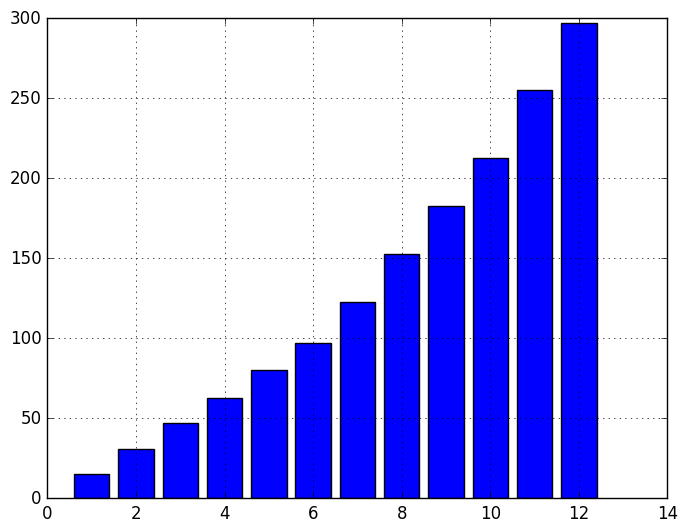

In [6]:
x = linspace(1,reductionPossible,reductionPossible)

using PyPlot
grid("on")
bar(x,y,align="center");

__c) The town council wants the builder to expedite the project. As an incentive, the council will pay
a bonus of \$30k/week for each week the work finishes early. When will the project be completed
if the builder is acting in a way that maximizes his profit?__

In [7]:
incentive = 30
[println(i," week reduction gives profit of \$",i*incentive - y[i],"k")
    for i in 1:reductionPossible];

1 week reduction gives profit of $15.0k
2 week reduction gives profit of $29.0k
3 week reduction gives profit of $43.0k
4 week reduction gives profit of $57.0k
5 week reduction gives profit of $70.0k
6 week reduction gives profit of $83.0k
7 week reduction gives profit of $87.0k
8 week reduction gives profit of $87.0k
9 week reduction gives profit of $87.0k
10 week reduction gives profit of $87.0k
11 week reduction gives profit of $75.0k
12 week reduction gives profit of $63.0k


The above code output shows that to maximize profit, the builder needs to finish the project early anywhere between 7-10 weeks. The profit would be \$87k